<ipython-input-3-8a97e1d40430>:50: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(original, denoised)


Median Filter - PSNR: 14.74, SSIM: 0.1892, MSE: 0.033608
Wavelet Filter - PSNR: 18.67, SSIM: 0.4972, MSE: 0.013596
Extracted 1431 frames from the video.


100%|██████████| 1431/1431 [00:21<00:00, 66.58it/s]


Processed videos saved.


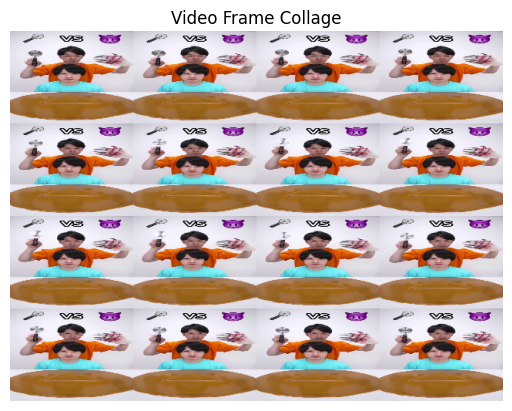

In [3]:
# Install required packages (only needed in Colab)
!pip install opencv-python scikit-image tqdm n2v --quiet PyWavelets

import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.restoration import denoise_wavelet
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
from n2v.models import N2V
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
import shutil

# Set up directories
os.makedirs('video_frames', exist_ok=True)
os.makedirs('processed_frames', exist_ok=True)
os.makedirs('denoised_results', exist_ok=True)

### PART 1: IMAGE DENOISING

def add_gaussian_noise(image):
    noise = np.random.normal(0, 0.1, image.shape)
    noisy = image + noise
    return np.clip(noisy, 0, 1)

def median_filter(img):
    return cv2.medianBlur((img * 255).astype(np.uint8), 3).astype(np.float32) / 255

def wavelet_denoise(img):
    return denoise_wavelet(img, channel_axis=-1, rescale_sigma=True)

def noise2void_denoise(img):
    # Prepare training data
    datagen = N2V_DataGenerator()
    imgs = datagen.generate_from_single_image(img, shape=(64, 64))
    X, Y = datagen.create_patches_from_list(imgs, shape=(64, 64))

    model = N2V(config={'unet_kern_size': 3, 'train_steps_per_epoch': 5,
                        'train_epochs': 1, 'train_batch_size': 2,
                        'n2v_perc_pix': 0.198, 'n2v_patch_shape': (64, 64),
                        'train_loss': 'mse', 'train_learning_rate': 1e-3})
    model.prepare_for_training()
    model.train(X, Y)

    return model.predict(img[np.newaxis])[0]

def compare_metrics(original, noisy, denoised, label):
    psnr = peak_signal_noise_ratio(original, denoised)
    # Specify data_range for structural_similarity
    ssim = structural_similarity(original, denoised, channel_axis=-1, data_range=1.0)  # Assuming data range is [0, 1]
    mse = mean_squared_error(original, denoised)
    print(f"{label} - PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, MSE: {mse:.6f}")

# Load image and test
original_img = img_as_float(io.imread('noise.png'))  # upload image in Colab
noisy_img = add_gaussian_noise(original_img)

# Apply filters
median_result = median_filter(noisy_img)
wavelet_result = wavelet_denoise(noisy_img)
# noise2void_result = noise2void_denoise(noisy_img)  # Uncomment if you want to run N2V (very slow)

compare_metrics(original_img, noisy_img, median_result, "Median Filter")
compare_metrics(original_img, noisy_img, wavelet_result, "Wavelet Filter")
# compare_metrics(original_img, noisy_img, noise2void_result, "Noise2Void")

### PART 2: EXTRACT IMAGES FROM VIDEO

video_path = '/content/videoplayback.mp4'  # Upload in Colab
cap = cv2.VideoCapture(video_path)
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f'video_frames/frame_{frame_count:04d}.jpg', frame)
    frame_count += 1
cap.release()
print(f"Extracted {frame_count} frames from the video.")

### PART 3: PROCESS VIDEO FRAMES

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
frame_size = (640, 480)
fps = 20

video_paths = {
    'threshold': 'adaptive_threshold.mp4',
    'blur': 'gaussian_blur.mp4',
    'canny': 'canny_edges.mp4',
    'invert': 'bitwise_not.mp4'
}

writers = {k: cv2.VideoWriter(path, fourcc, fps, frame_size, isColor=False) for k, path in video_paths.items()}

for i in tqdm(range(frame_count)):
    frame = cv2.imread(f'video_frames/frame_{i:04d}.jpg')
    frame = cv2.resize(frame, frame_size)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 100, 200)
    invert = cv2.bitwise_not(gray)

    writers['threshold'].write(thresh)
    writers['blur'].write(blur)
    writers['canny'].write(edges)
    writers['invert'].write(invert)

for writer in writers.values():
    writer.release()

print("Processed videos saved.")

### COLLAGE OF VIDEO FRAMES

def make_collage(images, grid_shape=(4, 4)):
    rows, cols = grid_shape
    collage_rows = []
    for i in range(0, len(images), cols):
        row_imgs = images[i:i + cols]
        row_imgs = [cv2.resize(img, (160, 120)) for img in row_imgs]
        collage_rows.append(np.hstack(row_imgs))
    return np.vstack(collage_rows)

sample_images = [cv2.imread(f'video_frames/frame_{i:04d}.jpg') for i in range(16)]
collage = make_collage(sample_images)
cv2.imwrite("video_collage.jpg", collage)
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Video Frame Collage")
plt.show()


In [8]:
import os
import cv2
import numpy as np

def extract_frames_from_video(video_path, num_frames=16, size=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total_frames // num_frames)

    count = 0
    while len(frames) < num_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % step == 0:
            frame = cv2.resize(frame, size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        count += 1

    cap.release()
    # Padding if needed
    while len(frames) < num_frames:
        frames.append(frames[-1])
    return np.array(frames)

# Example: preprocess all videos and save as numpy
classes = ["JumpingJack", "PushUps"]
base_path = "/content/data"
os.makedirs(base_path, exist_ok=True)

for cls in classes:
    input_dir = f"/content/{cls}_videos"  # Upload your 5 videos here per class
    output_dir = os.path.join(base_path, cls)
    os.makedirs(output_dir, exist_ok=True)
    for i, vid in enumerate(os.listdir(input_dir)):
        video_path = os.path.join(input_dir, vid)
        frames = extract_frames_from_video(video_path)
        frames = frames.astype(np.float32) / 127.5 - 1.0  # Normalize to [-1, 1]
        np.save(os.path.join(output_dir, f"video_{i}.npy"), frames)


In [9]:
# Dummy 3D GAN for demo (full model needs full codebase and training loop)
from tensorflow.keras import layers, models

def build_video_generator():
    model = models.Sequential()
    model.add(layers.Dense(256*4*4*4, input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 4, 256)))  # T x H x W x C
    model.add(layers.Conv3DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'))
    model.add(layers.Conv3DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'))
    model.add(layers.Conv3DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh'))  # (16, 64, 64, 3)
    return model

generator = build_video_generator()
noise = np.random.randn(1, 100).astype(np.float32)
generated_video = generator.predict(noise)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [10]:
import imageio

def save_as_gif(video_tensor, filename="output.gif"):
    video_tensor = ((video_tensor + 1.0) * 127.5).astype(np.uint8)
    imageio.mimsave(filename, video_tensor, fps=4)

save_as_gif(generated_video[0], "JumpingJack_fake.gif")
